# 0. Imports

In [1]:
import jax
from jax import vmap, jacrev
from jax.lax import scan
import jax.numpy as jnp
import jax.random as jr
from jax.tree_util import tree_map
import matplotlib.pyplot as plt

from dynamax.linear_gaussian_ssm import LinearGaussianSSM
from rebayes.extended_kalman_filter.sw_ekf import RebayesSWEKF, SWEKFParams
from rebayes.utils.utils import get_mlp_flattened_params

In [7]:
jnp.set_printoptions(precision=3, suppress=True)

# 1. Experiment 1

## 1.1 Dataset

In [2]:
def generate_dataset_1(q=10., r=100., dt=1, T=1_000, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jr.split(key)

    n_steps = int(T / dt)
    m0 = jnp.array([100., 100., 10., 10.])
    P0 = 100. * jnp.eye(m0.shape[0])
    
    # Sample first state
    x0 = jr.multivariate_normal(subkey, m0, P0)

    F = jnp.array([
        [1, 0, dt, 0],
        [0, 1, 0, dt],
        [0, 0, 1,  0],
        [0, 0, 0,  1],
    ])
    H = jnp.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
    ])
    Q = q * jnp.array([
        [(dt**3)/3,         0, (dt**2)/2,         0],
        [        0, (dt**3)/3,         0, (dt**2)/2],
        [(dt**2)/2,         0,        dt,         0],
        [        0, (dt**2)/2,         0,        dt]
    ])
    Q_fn = lambda k: Q * (6.5 + 0.5*jnp.cos(jnp.pi * k/T))
    R = r * jnp.array([
        [1.0, 0.5],
        [0.5, 1.0],
    ])
    R_fn = lambda k: R * (0.1 + 0.05*jnp.cos(jnp.pi * k/T))

    def _step(carry, args):
        x = carry
        key, i = args
        keys = jr.split(key)
        dynamics_noise = jr.multivariate_normal(keys[0], jnp.zeros(Q.shape[0]), (Q_fn(i)), method="eigh")
        x_next = F @ x + dynamics_noise
        emission_noise = jr.multivariate_normal(keys[1], jnp.zeros(R.shape[0]), (R_fn(i)), method="eigh")
        y = H @ x + emission_noise

        return x_next, (x, y)
    
    keys = jr.split(key, n_steps)
    _, (xs, ys) = scan(_step, m0, (keys, jnp.arange(1, n_steps+1)))
    
    return x0, xs, ys

In [3]:
def load_parameters1(q=10.0, r=100.0, dt=1.0, T=1_000):
    F = jnp.array([
        [1, 0, dt, 0],
        [0, 1, 0, dt],
        [0, 0, 1,  0],
        [0, 0, 0,  1],
    ])
    H = jnp.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
    ])
    Q = q * jnp.array([
        [dt**3/3,       0, dt**2/2,       0],
        [      0, dt**3/3,       0, dt**2/2],
        [dt**2/2,       0,      dt,       0],
        [      0, dt**2/2,       0,      dt]
    ])
    Q_fn = lambda k: Q * (6.5 + 0.5*jnp.cos(jnp.pi * k/T))
    Qs = jnp.array([Q_fn(k+1) for k in range(1_000)])
    R = r * jnp.array([
        [1.0, 0.5],
        [0.5, 1.0],
    ])
    R_fn = lambda k: R * (0.1 + 0.05*jnp.cos(jnp.pi * k/T))
    Rs = jnp.array([R_fn(k+1) for k in range(1_000)])
    
    return F, H, Qs, Rs

## 1.2 Experiment

In [4]:
def run_swvakf(alpha, m0, ys):
    F, H, *_ = load_parameters1()
    P0 = 100. * jnp.eye(m0.shape[0])
    f = lambda w: F @ w
    Q0 = alpha * jnp.eye(m0.shape[0])
    h = lambda w, x: H @ w
    R0 = 10.0 * jnp.eye(ys.shape[1])
    rho = jnp.exp(-4)
    
    params = SWEKFParams(
        dim_input = 1,
        dim_output = 2,
        initial_mean = m0,
        initial_covariance = P0,
        dynamics_function = f,
        dynamics_covariance = Q0,
        emission_mean_function = h,
        emission_cov_function = None,
        emission_covariance = R0,
        covariance_inflation_factor = rho,
        window_length = 5,
    )
    
    estimator = RebayesSWEKF(params)
    N = len(ys)
    Xs = jnp.zeros((N, 1))
    
    def callback(bel, *args, **kwargs):
        return bel.mean, bel.cov, bel.dynamics_cov, bel.emission_cov

    _, output = estimator.scan(Xs, ys, callback=callback)

    return output

In [5]:
# Evaluation metrics
def compute_armses(preds, truths):
    pos_rmse = jnp.sqrt(jnp.mean((preds[:,0] - truths[:,0])**2 + (preds[:,1] - truths[:,1])**2))
    vel_rmse = jnp.sqrt(jnp.mean((preds[:,2] - truths[:,2])**2 + (preds[:,3] - truths[:,3])**2))

    return pos_rmse, vel_rmse

def compute_asrnfns(preds, truths):
    n = preds.shape[1]
    srnfns = jnp.mean((jnp.linalg.norm((preds-truths)**2)/(n**2)))**(1/4)

    return srnfns

def compute_anees(m_pred, P_pred, m_truth):
    def compute_nees(m, P, mt):
        return (m - mt).T @ jnp.linalg.pinv(P) @ (m - mt)
    
    nees = jnp.mean(vmap(compute_nees, (0, 0, 0))(m_pred, P_pred, m_truth))

    return nees

def evaluate_swvakf(sw_ms, sw_Ps, sw_Qs, sw_Rs, xs, Qs, Rs):
    pos_rmse, vel_rmse = compute_armses(sw_ms, xs)
    q_srnfn, r_srnfn = compute_asrnfns(sw_Qs, Qs), compute_asrnfns(sw_Rs, Rs)
    nees = compute_anees(sw_ms, sw_Ps, xs)

    return pos_rmse, vel_rmse, q_srnfn, r_srnfn, nees

In [6]:
def run_experiment1(alpha_grid, n_iter=10, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    # True parameters
    q, r, dt, T = 10.0, 100.0, 1.0, 1_000
    F, H, Qs, Rs = load_parameters1(q, r, dt, T)

    def run_single_iter(key):
        # Generate dataset
        m0, ms, ys = generate_dataset_1(q, r, dt, T, key)

        # Run Optimal Kalman Filter
        lgssm = LinearGaussianSSM(state_dim = 4, emission_dim = 2, input_dim = 0)
        params_lgssm, _ = lgssm.initialize(
            initial_mean = m0,
            initial_covariance = 100. * jnp.eye(m0.shape[0]),
            dynamics_weights = F,
            dynamics_covariance = Qs,
            emission_weights = H,
            emission_covariance = Rs
        )

        # Evaluate Optimal Kalman Filter
        okf_posterior = lgssm.filter(params_lgssm, ys)
        okf_xs, okf_Ps = okf_posterior.filtered_means, okf_posterior.filtered_covariances
        okf_pos_armse, okf_vel_armse = compute_armses(okf_xs, ms)
        okf_anees = compute_anees(okf_xs, okf_Ps, ms)

        # Run and evaluate SW-VAKF
        sw_ms, sw_Ps, sw_Qs, sw_Rs = vmap(run_swvakf, (0, None, None))(alpha_grid, m0, ys)
        sw_pos_armses, sw_vel_armses, sw_q_asrnfns, sw_r_asrnfns, sw_anees = \
            vmap(evaluate_swvakf, (0, 0, 0, 0, None, None, None))(sw_ms, sw_Ps, sw_Qs, sw_Rs, ms, Qs, Rs)

        result = {
            "Qs": sw_Qs,
            "Rs": sw_Rs,
            "okf_pos_armse": okf_pos_armse,
            "okf_vel_armse": okf_vel_armse,
            "okf_anees": okf_anees,
            "swvakf_pos_armse": sw_pos_armses,
            "swvakf_vel_armse": sw_vel_armses,
            "swvakf_q_asrnfn": sw_q_asrnfns,
            "swvakf_r_asrnfn": sw_r_asrnfns,
            "swvakf_anees": sw_anees,
        }

        return result
    
    keys = jr.split(key, n_iter)
    result = vmap(run_single_iter)(keys)
    result = tree_map(lambda x: jnp.mean(x, axis=0), result) # Mean across MC trials

    return result

## 1.3 Results

In [15]:
alpha_grid = jnp.arange(5, 101, 5)
experiment_result = run_experiment1(alpha_grid, n_iter=100)

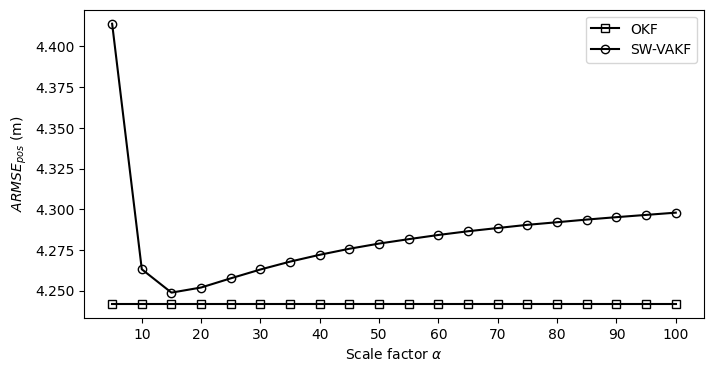

In [10]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(alpha_grid, [experiment_result["okf_pos_armse"]] * len(alpha_grid), '-ks',
        markerfacecolor='None', label="OKF")
ax.plot(alpha_grid, experiment_result["swvakf_pos_armse"], '-ko', 
        markerfacecolor='None', label="SW-VAKF")
ax.set_xlabel(r"Scale factor $\alpha$")
ax.set_ylabel(r"$ARMSE_{pos}$ (m)")
ax.legend();
ax.set_xticks(alpha_grid[1::2]);
# ax.set_ylim(4.10, 100.40);

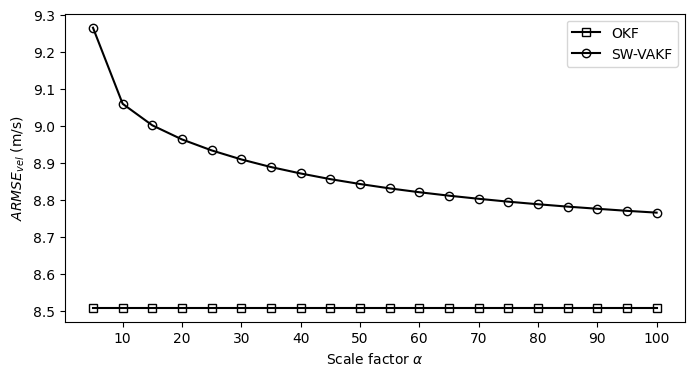

In [11]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(alpha_grid, [experiment_result["okf_vel_armse"]] * len(alpha_grid), '-ks',
        markerfacecolor='None', label="OKF")
ax.plot(alpha_grid, experiment_result["swvakf_vel_armse"], '-ko', 
        markerfacecolor='None', label="SW-VAKF");
ax.set_xlabel(r"Scale factor $\alpha$")
ax.set_ylabel(r"$ARMSE_{vel}$ (m/s)")
ax.set_xticks(alpha_grid[1::2])
ax.legend();

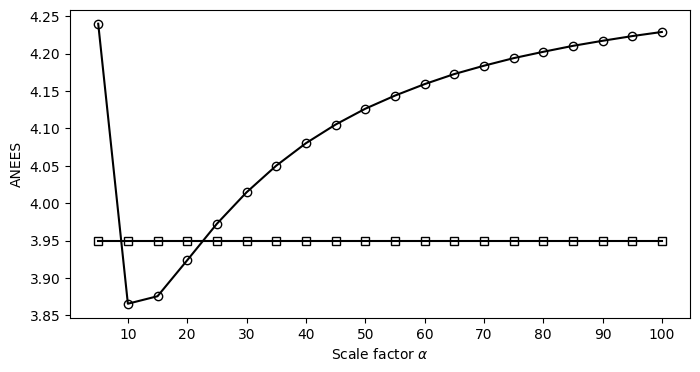

In [12]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(alpha_grid, [experiment_result["okf_anees"]] * len(alpha_grid), '-ks',
        markerfacecolor='None', label="OKF")
ax.plot(alpha_grid, experiment_result["swvakf_anees"], '-ko', 
        markerfacecolor='None', label="SW-VAKF");
ax.set_xlabel(r"Scale factor $\alpha$")
ax.set_ylabel(r"ANEES");
ax.set_xticks(alpha_grid[1::2]);

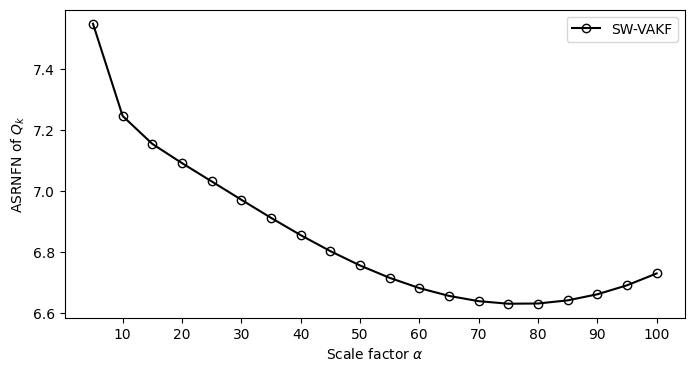

In [13]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(alpha_grid, experiment_result["swvakf_q_asrnfn"], '-ko', 
        markerfacecolor='None', label="SW-VAKF");
ax.set_xlabel(r"Scale factor $\alpha$")
ax.set_ylabel(r"ASRNFN of $Q_k$")
ax.set_xticks(alpha_grid[1::2])
ax.legend();

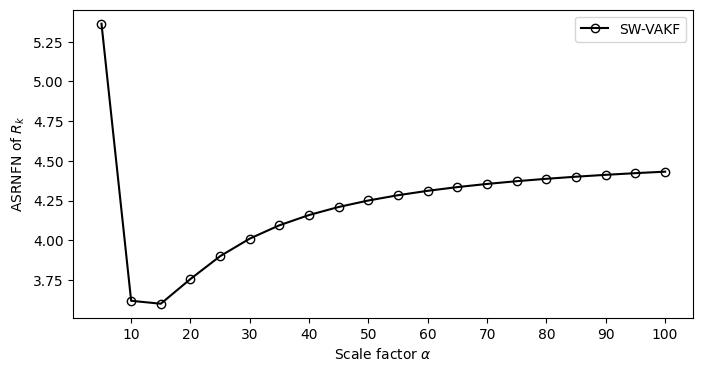

In [14]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(alpha_grid, experiment_result["swvakf_r_asrnfn"], '-ko', 
        markerfacecolor='None', label="SW-VAKF");
ax.set_xlabel(r"Scale factor $\alpha$")
ax.set_ylabel(r"ASRNFN of $R_k$")
ax.set_xticks(alpha_grid[1::2])
ax.legend();

## Control